**Question No.1**. Vision Dataset: imagenette/160px-v2- Imagenette is a subset of 10 easily classified classes from the Imagenet dataset.

Solution Notebook:

# Import Libraries/Dataset

In [1]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.3MB/s 


In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import pathlib
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
data_dir = tf.keras.utils.get_file('imagenette2-160', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

99008512/99003388 [==============================] - 3s 0us/step
/root/.keras/datasets/imagenette2-160


In [4]:
image_count = len(list(data_dir.glob('*/*/*.JPEG')))
print(image_count)

13394


In [5]:
batch_size = 64

In [6]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "/root/.keras/datasets/imagenette2-160/train",
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=batch_size)

Found 9469 files belonging to 10 classes.
Using 7576 files for training.


In [7]:
testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "/root/.keras/datasets/imagenette2-160/val",
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=batch_size)

Found 3925 files belonging to 10 classes.
Using 785 files for validation.


In [8]:
class_names = training_dataset.class_names
print(class_names)

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


# Data Visualization and augmentation

> sample from each class


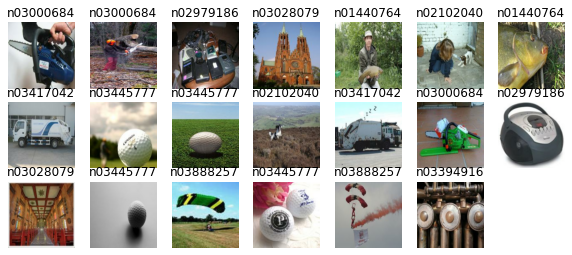

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(20):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

> original and augumentes sample from each class

> Indented block



In [10]:
def augument_img(image):
  image= tf.cast(tf.image.resize(image,[160,160]), tf.float32) / 255.
  image= tf.image.flip_up_down(image)
  return image

def visualize(title, original, augmented):
  import matplotlib.pyplot as plt
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title(title+'(Original)')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title(title+'(Augmented)')
  plt.imshow(augmented)

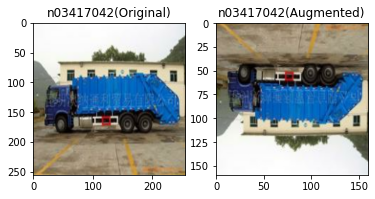

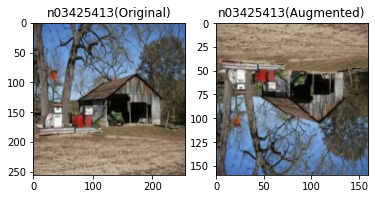

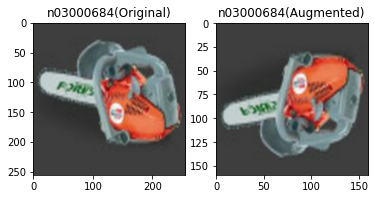

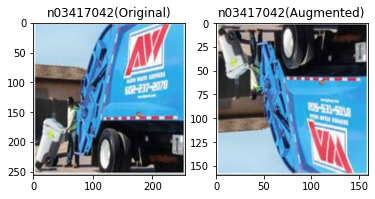

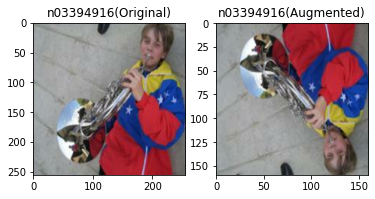

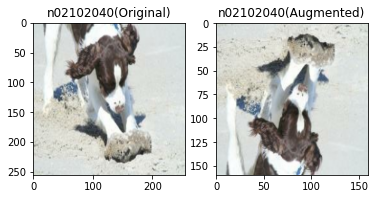

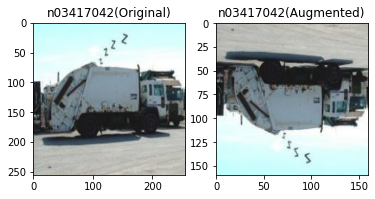

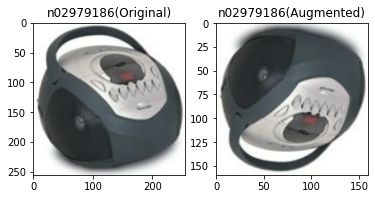

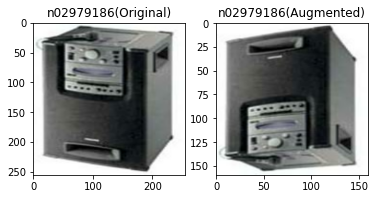

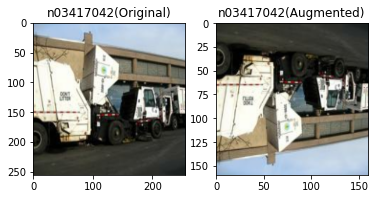

In [11]:
for images, labels in training_dataset.take(1):
  for i in range(10):
    image=images[i].numpy().astype("uint8")
    title=class_names[labels[i]]
    visualize(title,image,augument_img(image))

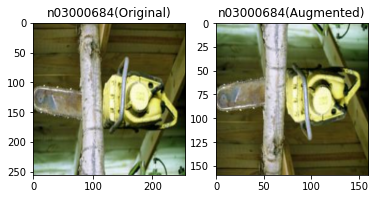

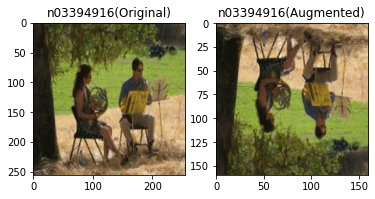

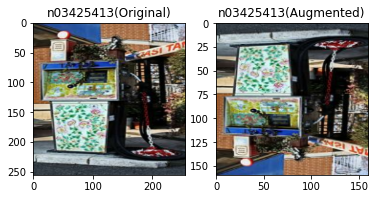

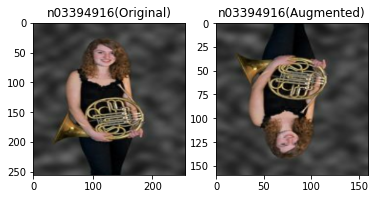

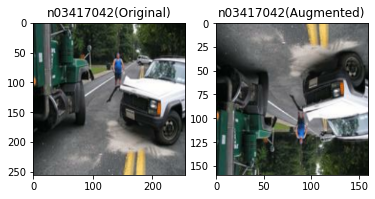

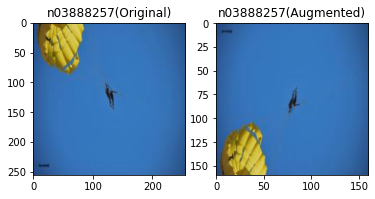

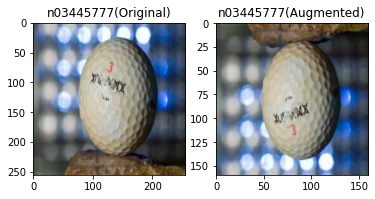

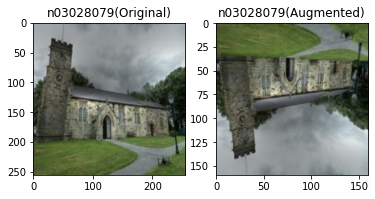

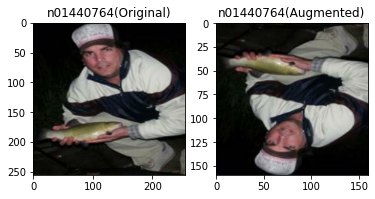

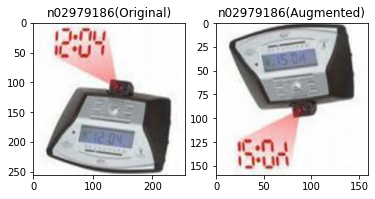

In [12]:
for images, labels in testing_dataset.take(1):
  for i in range(10):
    image=images[i].numpy().astype("uint8")
    title=class_names[labels[i]]
    visualize(title,image,augument_img(image))

# Data Agumentation

In [13]:
import tensorflow_datasets as tfds

try:
  (ds_train, ds_test), ds_info = tfds.load(
      'imagenette/160px-v2',
      split=['train', 'validation'],
      shuffle_files=True,
      as_supervised=True,
      with_info=True,
  )
except:
    (ds_train, ds_test), ds_info = tfds.load(
      'imagenette/160px-v2',
      split=['train', 'validation'],
      shuffle_files=True,
      as_supervised=True,
      with_info=True,
  )

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0.incomplete9ATDZU/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0.incomplete9ATDZU/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0. Subsequent calls will reuse this data.


> Configure the dataset for performance



In [14]:
IMG_SIZE = 160

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

> Standardize the data

In [17]:
ds_train = prepare(ds_train, shuffle=True, augment=True)
ds_test = prepare(ds_test)

# **Hyper parameter tuning**

> # 1. Model Building with adam optimizer

In [18]:
from tensorflow import keras
import kerastuner as kt
from tensorflow.python.keras import regularizers

In [19]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(160, 160,3)))
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(hp_units,kernel_regularizer='l2',activation='relu')) # hidden layer 1
  model.add(keras.layers.Dense(hp_units,kernel_regularizer='l2',activation='relu')) # hidden layer 2
  model.add(keras.layers.Dense(hp_units,kernel_regularizer='l2',activation='relu')) # hidden layer 3
  model.add(keras.layers.Dropout(0.1))  # dropout layer
  model.add(keras.layers.Dense(10,activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

Model Compilation

In [20]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     hyperband_iterations=2)

tuner.search(ds_train,
             validation_data=ds_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 64 Complete [00h 02m 45s]
val_accuracy: 0.23312102258205414

Best val_accuracy So Far: 0.3757961690425873
Total elapsed time: 04h 23m 08s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [21]:
print(f"""
The hyperparameter search is complete. 
the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and no of 
nodes in first hidden layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. 
the optimal learning rate for the optimizer
is 0.0001 and no of 
nodes in first hidden layer is 352.



Model Training

> Build the model with the optimal hyperparameters and train it



In [22]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
print('Training model...')
from time import time

start = time()
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(ds_train, epochs=50, validation_data=ds_test)

print('Training duration is :')
print(time()-start)
print('Training finished !!')

Training model...
Epoch 1/50
148/148 [==============================] - 89s 593ms/step - loss: 14.4501 - accuracy: 0.1547 - val_loss: 10.0088 - val_accuracy: 0.2061
Epoch 2/50
148/148 [==============================] - 90s 602ms/step - loss: 9.2779 - accuracy: 0.2360 - val_loss: 7.5494 - val_accuracy: 0.2668
Epoch 3/50
148/148 [==============================] - 89s 597ms/step - loss: 7.1927 - accuracy: 0.2516 - val_loss: 6.1661 - val_accuracy: 0.2683
Epoch 4/50
148/148 [==============================] - 89s 599ms/step - loss: 5.9337 - accuracy: 0.2720 - val_loss: 5.2458 - val_accuracy: 0.3103
Epoch 5/50
148/148 [==============================] - 90s 601ms/step - loss: 5.0911 - accuracy: 0.2921 - val_loss: 4.6187 - val_accuracy: 0.2991
Epoch 6/50
148/148 [==============================] - 89s 599ms/step - loss: 4.5186 - accuracy: 0.2972 - val_loss: 4.1804 - val_accuracy: 0.3068
Epoch 7/50
148/148 [==============================] - 91s 608ms/step - loss: 4.1052 - accuracy: 0.3033 - val_l

 Model Evaluation 

In [23]:
eval_result = hypermodel.evaluate(ds_test)
print("[test loss, test accuracy]:", eval_result)

62/62 [==============================] - 10s 155ms/step - loss: 1.9457 - accuracy: 0.3822
[test loss, test accuracy]: [1.945719599723816, 0.3821656107902527]


> Print the final train and validation loss and accuracy.

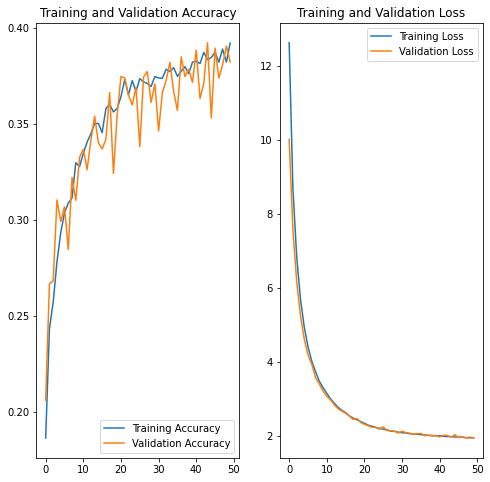

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 Plot confusion matrix

Confusion matrix, without normalization
[[167  24  13  12  33  89  16  10  19   4]
 [ 36  76  40  19  31 102  14  37  25  15]
 [  3  17 201   7  16  49  18  23  17   6]
 [ 30  34  53  54  16 144   8  27   9  11]
 [ 14   6  13   6 209  96  11  10  10  34]
 [ 17  21  15  27  34 228   5  28   8  11]
 [ 18  12  76  11  64  33 106  36  10  23]
 [ 12  26  58  21  41 132  13  70  20  26]
 [ 30  14  25   6  41  51   6  26 162  38]
 [ 10   7  16  19  41  35  15   7  13 227]]


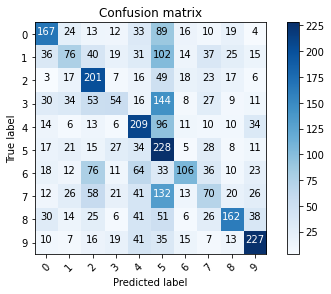

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

def dataset2numpy(dataset, steps=1):
    "Helper function to get data/labels back from TF dataset"
    iterator = dataset.make_one_shot_iterator()
    next_val = iterator.get_next()
    with tf.Session() as sess:
        for _ in range(steps):
           inputs, labels = sess.run(next_val)
           yield inputs, labels

y_test = np.concatenate([y for x, y in ds_test], axis=0)
p_test = hypermodel.predict(ds_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

Show some misclassified examples

In [26]:
correctly_classified_idx=np.where(p_test == y_test)[0]
print(correctly_classified_idx)

[   0    2    3 ... 3921 3922 3924]


In [27]:
misclassified_idx = np.where(p_test != y_test)[0]
print(misclassified_idx)

[   1    5    7 ... 3914 3916 3923]


> # 2. Model Building with RMSprop Optimizer

In [28]:
# Build the model
hypermodel_with_rms = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(160, 160,3)),
  tf.keras.layers.Dense(352, kernel_regularizer='l2',activation='relu'),
  tf.keras.layers.Dense(352, kernel_regularizer='l2',activation='relu'),
  tf.keras.layers.Dense(352, kernel_regularizer='l2',activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation='softmax')
])


# Compile the model
hypermodel_with_rms.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = hypermodel_with_rms.fit(ds_train, epochs=50, validation_data=ds_test)

eval_result_wi_rms = hypermodel_with_rms.evaluate(ds_test)
print("[test loss, test accuracy]:", eval_result_wi_rms)


Epoch 1/50
148/148 [==============================] - 113s 749ms/step - loss: 28.9745 - accuracy: 0.0994 - val_loss: 6.4323 - val_accuracy: 0.1062
Epoch 2/50
148/148 [==============================] - 110s 740ms/step - loss: 4.1524 - accuracy: 0.0967 - val_loss: 2.5408 - val_accuracy: 0.1029
Epoch 3/50
148/148 [==============================] - 111s 743ms/step - loss: 2.5544 - accuracy: 0.1166 - val_loss: 2.4997 - val_accuracy: 0.0996
Epoch 4/50
148/148 [==============================] - 110s 738ms/step - loss: 2.4318 - accuracy: 0.1058 - val_loss: 2.3398 - val_accuracy: 0.1004
Epoch 5/50
148/148 [==============================] - 110s 738ms/step - loss: 2.4282 - accuracy: 0.1088 - val_loss: 2.3477 - val_accuracy: 0.1414
Epoch 6/50
148/148 [==============================] - 110s 738ms/step - loss: 2.3965 - accuracy: 0.1121 - val_loss: 2.3669 - val_accuracy: 0.1017
Epoch 7/50
148/148 [==============================] - 110s 739ms/step - loss: 2.4534 - accuracy: 0.1181 - val_loss: 2.4278 

# Model Comparison with two different optimizer

In [29]:
print(f'Adam optimizer accuracy is [test loss, test accuracy] : {eval_result} and \n RMSprop optimizer accuracy is [test loss, test accuracy] : {eval_result_wi_rms}')

Adam optimizer accuracy is [test loss, test accuracy] : [1.945719599723816, 0.3821656107902527] and 
 RMSprop optimizer accuracy is [test loss, test accuracy] : [2.4348554611206055, 0.10038216412067413]


# conclusion

**Hyperparameter Tuning**- Build two more additional models by changing the following hyperparameters ONE at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.
1. Network Depth: Change the number of hidden layers and hidden units for each layer
2. Optimizer: Use a different optimizer with the appropriate LR value

Answer:


we implemented hyperparameter tuning based on selection of following things


> a) 'units' as no of nodes in hidden layer which is Network Depth

> b) 'learning_rate' as learning rate value

> c) 'epoc' value as 50 as it gives no better result than this

> d) 'dropout' as 0.1 performs better 

